# **Многоклассовая классификация заболеваний сои с применением методов снижения размерности и подбора гиперпараметров**

Выполнить многоклассовую классификацию заболеваний сои (fetch_ucirepo(id=90)) из пакета ucimlrepo . Необходимо обучить 2-3 модели, оптимизировать гиперпараметры, сравнить модели по F1.

# Загрузка и подготовка данных

In [ ]:
!pip install ucimlrepo

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from catboost import CatBoostClassifier
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ucimlrepo import fetch_ucirepo
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

Загрузим большой набор данных о соевых бобах. Это классический набор данных в области диагностики и классификации болезней растений. Набор данных "Soybean (Large)" был создан для задачи многоклассовой классификации: определение конкретного заболевания соевых бобов на основе различных симптомов и характеристик растения.

In [ ]:
soybean_large = fetch_ucirepo(id=90)

In [ ]:
soybean_large.metadata

{'uci_id': 90,
 'name': 'Soybean (Large)',
 'repository_url': 'https://archive.ics.uci.edu/dataset/90/soybean+large',
 'data_url': 'https://archive.ics.uci.edu/static/public/90/data.csv',
 'abstract': "Michalski's famous soybean disease database",
 'area': 'Biology',
 'tasks': ['Classification'],
 'characteristics': ['Multivariate'],
 'num_instances': 307,
 'num_features': 35,
 'feature_types': ['Categorical'],
 'demographics': [],
 'target_col': ['class'],
 'index_col': None,
 'has_missing_values': 'yes',
 'missing_values_symbol': 'NaN',
 'year_of_dataset_creation': 1980,
 'last_updated': 'Sun Feb 11 2024',
 'dataset_doi': '10.24432/C5JG6Z',
 'creators': ['R.S. Michalski', 'R.L. Chilausky'],
 'intro_paper': None,
 'additional_info': {'summary': 'There are 19 classes, only the first 15 of which have been used in prior work. The folklore seems to be that the last four classes are unjustified by the data since they have so few examples. There are 35 categorical attributes, some nominal a

Это база данных о заболеваниях сои, созданная в 1988 году. В наборе 35 категориальных атрибутов, которые относятся к разным классам. Набор данных содержит 19 классов и 307 наблюдений. Загрузим признаки и целевую переменную.

In [ ]:
X = soybean_large.data.features
y = soybean_large.data.targets

In [ ]:
print(soybean_large.variables)

               name     role         type demographic  \
0             class   Target  Categorical        None   
1              date  Feature  Categorical        None   
2       plant-stand  Feature  Categorical        None   
3            precip  Feature  Categorical        None   
4              temp  Feature  Categorical        None   
5              hail  Feature  Categorical        None   
6         crop-hist  Feature  Categorical        None   
7      area-damaged  Feature  Categorical        None   
8          severity  Feature  Categorical        None   
9          seed-tmt  Feature  Categorical        None   
10      germination  Feature  Categorical        None   
11     plant-growth  Feature  Categorical        None   
12           leaves  Feature  Categorical        None   
13   leafspots-halo  Feature  Categorical        None   
14   leafspots-marg  Feature  Categorical        None   
15    leafspot-size  Feature  Categorical        None   
16      leaf-shread  Feature  C

Признаки описывают различные наблюдаемые характеристики растений,  окружающей среды, симптомов заболеваний:

1.	date	Месяц наблюдения: апрель, май, июнь, июль, август, сентябрь, октябрь.

2.	plant-stand	Состояние всходов: нормальное, ниже нормального.

3.	precip	Уровень осадков: ниже нормы, норма, выше нормы.

4.	temp	Температура: ниже нормы, норма, выше нормы.

5.	hail	Град: да, нет.

6.	crop-hist	История севооборота: другой культурой в прошлом году, той же культурой в прошлом году, той же культурой 2 года подряд, той же культурой несколько лет подряд.

7.	area-damaged	Площадь повреждений: рассеянные, низменности, возвышенности, все поле.

8.	severity	Степень тяжести (повреждений): незначительная, потенциально тяжелая, тяжелая.

9.	seed-tmt	Обработка семян: нет, фунгицид, другое.

10.	germination	Прорастание (%): 90-100%, 80-89%, менее 80%.

11.	plant-growth	Рост растения: нормальный, ненормальный.

12.	leaves	Листья: нормальные, ненормальные.

13.	leafspots-halo	Ореол пятен на листьях: отсутствует, желтый ореол, нет желтого ореола.

14.	leafspots-marg	Края пятен на листьях: с водянистым налетом, без водянистого налета, неприменимо (dna).

15.	leafspot-size	Размер пятен на листьях: менее 1/8 дюйма, более 1/8 дюйма, неприменимо (dna).

16.	leaf-shread	Измельчение/разрыв листьев: отсутствует, присутствует.
17.	leaf-malf	Деформация листьев: отсутствует, присутствует.

18.	leaf-mild	Мучнистая роса на листьях: отсутствует, на верхней поверхности, на нижней поверхности.

19.	stem	Стебель: нормальный, ненормальный.

20.	lodging	Полегание (склонность падать): да, нет.

21.	stem-cankers	Язвы на стебле: отсутствуют, присутствуют.

22.	canker-lesion	Поражения от язв: коричневые в нижней части, коричневые равномерно, темно-коричневые/черные, неприменимо (dna).

23.	fruiting-bodies	Плодовые тела: отсутствуют, присутствуют.

24.	external-decay	Внешний распад (гниение): отсутствует, присутствует.

25.	mycelium	Мицелий: отсутствует, присутствует.

26.	int-discolor	Внутреннее обесцвечивание стебля: отсутствует, коричневое, черное.

27.	sclerotia	Склероции (твердые образования грибов): отсутствуют, присутствуют.

28.	fruit-pods	Стручки плодов: нормальные, ненормальные, неприменимо (dna).

29.	fruit-spots	Пятна на стручках: отсутствуют, коричневые/черные, коричневые пятна неправильной формы, неприменимо (dna).

30.	seed	Семена: нормальные, ненормальные, неприменимо (dna).

31.	mold-growth	Рост плесени: отсутствует, присутствует.

32.	seed-discolor	Обесцвечивание семян: отсутствует, присутствует.

33.	seed-size	Размер семян: нормальный, ниже нормального, неприменимо (dna).

34.	shriveling	Смощивание/усыхание: отсутствует, присутствует.

35.	roots	Корни: нормальные, ненормальные, неприменимо (dna).

Все признаки являются категориальными и содержат пропуски.

Целевой переменной является одно из 19 возможных заболеваний сои.


In [ ]:
X

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,plant-growth,leaves,leafspots-halo,leafspots-marg,leafspot-size,leaf-shread,leaf-malf,leaf-mild,stem,lodging,stem-cankers,canker-lesion,fruiting-bodies,external-decay,mycelium,int-discolor,sclerotia,fruit-pods,fruit-spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots
0,6.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1,0.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,2.0,1.0,0.0,2.0,0.0,2.0,1.0,1.0,1.0,1,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,2.0,1.0,1,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,1,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,1,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,1.0,1.0,NaN,0.0,NaN,1.0,0.0,NaN,NaN,NaN,1.0,1,2.0,1.0,1.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
304,0.0,1.0,NaN,0.0,NaN,0.0,3.0,NaN,NaN,NaN,1.0,1,0.0,2.0,2.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
305,1.0,1.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,1,0.0,2.0,2.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
print(X.nunique())
print(y.nunique())

date               7
plant-stand        2
precip             3
temp               3
hail               2
crop-hist          4
area-damaged       4
severity           3
seed-tmt           3
germination        3
plant-growth       2
leaves             2
leafspots-halo     3
leafspots-marg     3
leafspot-size      3
leaf-shread        2
leaf-malf          2
leaf-mild          3
stem               2
lodging            2
stem-cankers       4
canker-lesion      4
fruiting-bodies    2
external-decay     2
mycelium           2
int-discolor       3
sclerotia          2
fruit-pods         4
fruit-spots        4
seed               2
mold-growth        2
seed-discolor      2
seed-size          2
shriveling         2
roots              3
dtype: int64
class    19
dtype: int64


In [ ]:
print(X.isna().sum())
print(y.isna().sum())

date                1
plant-stand         8
precip             11
temp                7
hail               41
crop-hist           1
area-damaged        1
severity           41
seed-tmt           41
germination        36
plant-growth        1
leaves              0
leafspots-halo     25
leafspots-marg     25
leafspot-size      25
leaf-shread        26
leaf-malf          25
leaf-mild          30
stem                1
lodging            41
stem-cankers       11
canker-lesion      11
fruiting-bodies    35
external-decay     11
mycelium           11
int-discolor       11
sclerotia          11
fruit-pods         25
fruit-spots        35
seed               29
mold-growth        29
seed-discolor      35
seed-size          29
shriveling         35
roots               7
dtype: int64
class    0
dtype: int64


In [ ]:
X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             306 non-null    float64
 1   plant-stand      299 non-null    float64
 2   precip           296 non-null    float64
 3   temp             300 non-null    float64
 4   hail             266 non-null    float64
 5   crop-hist        306 non-null    float64
 6   area-damaged     306 non-null    float64
 7   severity         266 non-null    float64
 8   seed-tmt         266 non-null    float64
 9   germination      271 non-null    float64
 10  plant-growth     306 non-null    float64
 11  leaves           307 non-null    int64  
 12  leafspots-halo   282 non-null    float64
 13  leafspots-marg   282 non-null    float64
 14  leafspot-size    282 non-null    float64
 15  leaf-shread      281 non-null    float64
 16  leaf-malf        282 non-null    float64
 17  leaf-mild       

 Выведем уникальные значения целевой переменной и количество элементов в каждом классе.

In [ ]:
y["class"].unique()

array(['diaporthe-stem-canker', 'charcoal-rot', 'rhizoctonia-root-rot',
       'phytophthora-rot', 'brown-stem-rot', 'powdery-mildew',
       'downy-mildew', 'brown-spot', 'bacterial-blight',
       'bacterial-pustule', 'purple-seed-stain', 'anthracnose',
       'phyllosticta-leaf-spot', 'alternarialeaf-spot',
       'frog-eye-leaf-spot', 'diaporthe-pod-&-stem-blight',
       'cyst-nematode', '2-4-d-injury', 'herbicide-injury'], dtype=object)

In [ ]:
y['class'].value_counts()

,count
class,
frog-eye-leaf-spot,40
phytophthora-rot,40
alternarialeaf-spot,40
brown-spot,40
brown-stem-rot,20
anthracnose,20
diaporthe-stem-canker,10
purple-seed-stain,10
phyllosticta-leaf-spot,10


Посмотрим количество пропусков в признаках для каждого класса, чтобы оценить достаточно ли информации.

In [ ]:
print("Количество пропусков в каждом классе:")
df = pd.merge(X, y, left_index=True, right_index=True)
for c in list(df['class'].unique()):
  print(f"{c}: {df[df['class'] == c].isna().sum().sum()}")

Количество пропусков в каждом классе:
diaporthe-stem-canker: 0
charcoal-rot: 0
rhizoctonia-root-rot: 0
phytophthora-rot: 390
brown-stem-rot: 0
powdery-mildew: 0
downy-mildew: 0
brown-spot: 0
bacterial-blight: 0
bacterial-pustule: 0
purple-seed-stain: 0
anthracnose: 0
phyllosticta-leaf-spot: 0
alternarialeaf-spot: 0
frog-eye-leaf-spot: 0
diaporthe-pod-&-stem-blight: 68
cyst-nematode: 144
2-4-d-injury: 30
herbicide-injury: 80


Удалим пропуски, так как почти все они находятся в нескольких классах с небольшим количеством значений.

In [ ]:
df = df.dropna()

In [ ]:
df['class'].value_counts()

,count
class,
brown-spot,40
alternarialeaf-spot,40
frog-eye-leaf-spot,40
brown-stem-rot,20
anthracnose,20
phytophthora-rot,16
diaporthe-stem-canker,10
charcoal-rot,10
rhizoctonia-root-rot,10


In [ ]:
cat_f = list(df.columns)

Преобразуем признаки в категориальные.

In [ ]:
cat_f

['date',
 'plant-stand',
 'precip',
 'temp',
 'hail',
 'crop-hist',
 'area-damaged',
 'severity',
 'seed-tmt',
 'germination',
 'plant-growth',
 'leaves',
 'leafspots-halo',
 'leafspots-marg',
 'leafspot-size',
 'leaf-shread',
 'leaf-malf',
 'leaf-mild',
 'stem',
 'lodging',
 'stem-cankers',
 'canker-lesion',
 'fruiting-bodies',
 'external-decay',
 'mycelium',
 'int-discolor',
 'sclerotia',
 'fruit-pods',
 'fruit-spots',
 'seed',
 'mold-growth',
 'seed-discolor',
 'seed-size',
 'shriveling',
 'roots',
 'class']

In [ ]:
for colname in cat_f:
    df[colname] = pd.Categorical(df[colname])

df[cat_f].dtypes

,0
date,category
plant-stand,category
precip,category
temp,category
hail,category
crop-hist,category
area-damaged,category
severity,category
seed-tmt,category
germination,category


In [ ]:
df[colname].dtype

CategoricalDtype(categories=['alternarialeaf-spot', 'anthracnose', 'bacterial-blight',
                  'bacterial-pustule', 'brown-spot', 'brown-stem-rot',
                  'charcoal-rot', 'diaporthe-stem-canker', 'downy-mildew',
                  'frog-eye-leaf-spot', 'phyllosticta-leaf-spot',
                  'phytophthora-rot', 'powdery-mildew', 'purple-seed-stain',
                  'rhizoctonia-root-rot'],
, ordered=False, categories_dtype=object)

Посмотрим тепловую карту признаков, чтобы понять их связь.

<Axes: >

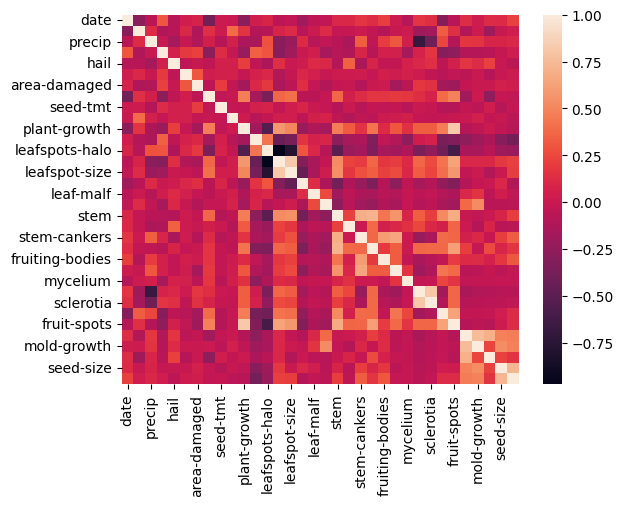

In [ ]:
sns.heatmap(df.iloc[:,0:34].corr())

Признак "ореол пятен на листьях" сильно связан с признаками "рост растений", "размер пятен на листьях", "плодовые пятна", а также признаки "осадки" и "склероции"имеют высокую взаимосвязь. Вероятно, необходимо уменьшение размерности для сокращения избыточности и шума в данных, что упростит и ускорит обучение модели, сохраняя при этом наиболее значимую информацию.

Попробуем выполнить снижение размерности при помощи PCA, так как метод оптимально подходит, потому что эффективно находит новые ортогональные признаки (главные компоненты), которые максимально сохраняют дисперсию исходных данных, устраняя корреляции. Это особенно важно для данного набора данных, так как все признаки являются категориальными и будут закодированы через OneHotEncoder, что создаст разреженные и избыточные данные.



# Применение PCA и снижение размерности

Попробуем найти оптимальное количество компонент для модели.

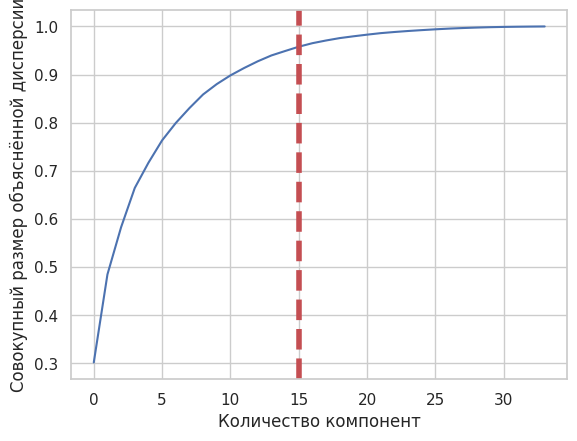

None

,Совокупный размер объяснённой дисперсии,Объясненный коэффициент дисперсии
0,0.301770,0.301770
1,0.484669,0.182899
2,0.582803,0.098134
3,0.664282,0.081479
4,0.716666,0.052384
5,0.763162,0.046496
6,0.799189,0.036027
7,0.830219,0.031031
8,0.858557,0.028338
9,0.880067,0.021510


In [ ]:
pca_test = PCA(n_components=34)
pca_test.fit(df.drop('class', axis=1))
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Количество компонент')
plt.ylabel('Совокупный размер объяснённой дисперсии')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=15, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Совокупный размер объяснённой дисперсии'] = cvr
pca_df['Объясненный коэффициент дисперсии'] = evr
display(pca_df.head(20))

Использование PCA для перехода от 35 переменных к 15 компонентам позволяет объяснить 95% дисперсии данных. Другие 20 компонент объясняют менее 5% дисперсии, а это значит, что от них можно отказаться. Следуя этой логике, воспользуемся PCA для уменьшения числа компонент с 35 до 15.

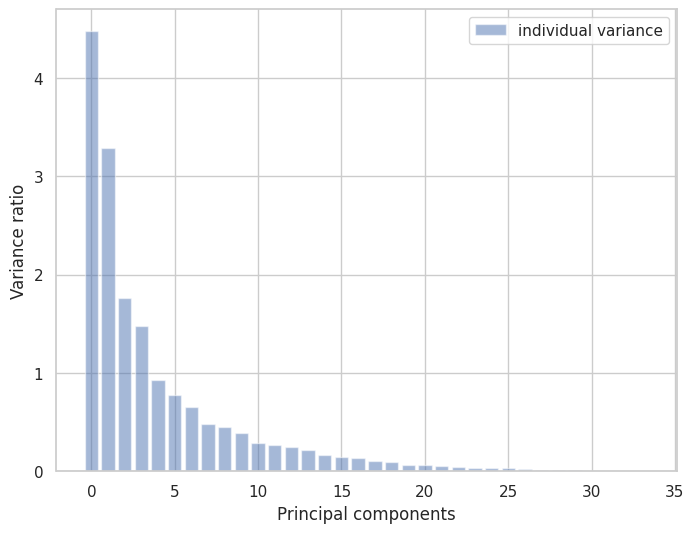

In [ ]:
pca = PCA()
pca.fit_transform(df.iloc[:,0:34])
pca_variance = pca.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(34), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

Преобразуем эти призаки в 15 лучших и построим точечную диаграмму классификации точек данных на основе этих признаков.

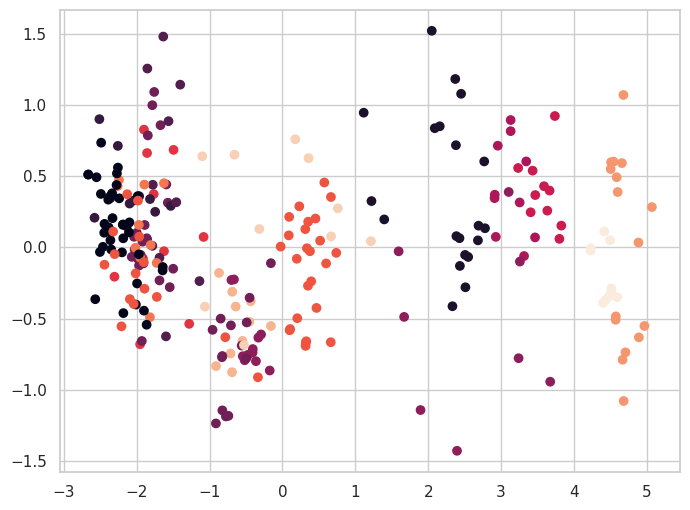

In [ ]:
pca_14 = PCA(n_components=14)
pca_14.fit(df.iloc[:,0:34])
x_3d = pca_14.transform(df.iloc[:,0:34])

plt.figure(figsize=(8,6))
plt.scatter(x_3d[:,0], x_3d[:,11], c=LabelEncoder().fit_transform(df["class"]))
plt.show()

Также сделаем это для топ-2 признаков и посмотрим, как изменится классификация:

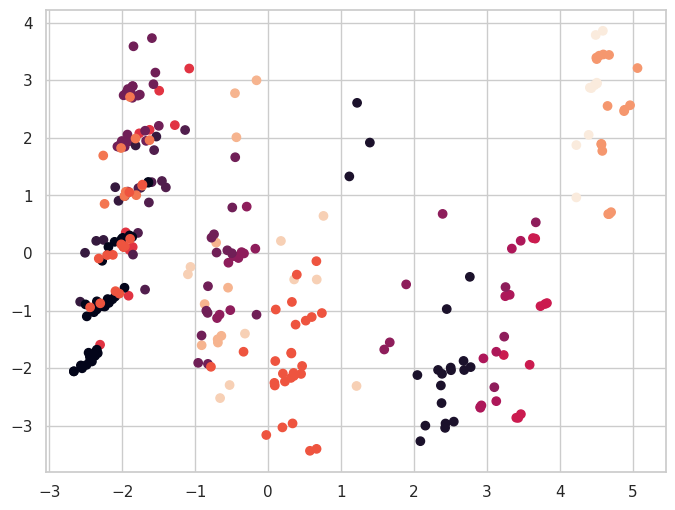

In [ ]:
pca_2 = PCA(n_components=2)
pca_2.fit(df.iloc[:,0:34])
x_3d = pca_2.transform(df.iloc[:,0:34])

plt.figure(figsize=(8,6))
plt.scatter(x_3d[:,0], x_3d[:,1], c=LabelEncoder().fit_transform(df["class"]))
plt.show()

На графиках видно, что главные компоненты демонстрируют четкое различие между  выходными классами.

Разделим данные на тренировочные и тестовые.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('class', axis=1), df['class'], test_size=0.3, random_state=42)

# Обучение и оптимизация моделей

## LogisticRegression

Обучим модель логистической регрессии на разном количестве компонент, предварительно преобразовав признаки.

In [ ]:
preprocess = make_column_transformer(
    ((OneHotEncoder(), X_train.columns))
)

Возьмем 15 компонент.

In [ ]:
pca_15 = PCA(n_components=15)
pca_15.fit(X_train)

PCA(n_components=15)

In [ ]:
lr = LogisticRegression()

In [ ]:
mod_lr = Pipeline([('preprocess', preprocess), ('pca', pca_15), ('lr', lr)])
mod_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  Index(['date', 'plant-stand', 'precip', 'temp', 'hail', 'crop-hist',
       'area-damaged', 'severity', 'seed-tmt', 'germination', 'plant-growth',
       'leaves', 'leafspots-halo', 'leafspots-marg', 'leafspot-size',
       'leaf-shread', 'leaf-malf', 'leaf-mild', 'stem', 'lodging',
       'stem-cankers', 'canker-lesion', 'fruiting-bodies', 'external-decay',
       'mycelium', 'int-discolor', 'sclerotia', 'fruit-pods', 'fruit-spots',
       'seed', 'mold-growth', 'seed-discolor', 'seed-size', 'shriveling',
       'roots'],
      dtype='object'))])),
                ('pca', PCA(n_components=15)), ('lr', LogisticRegression())])

In [ ]:
pred_lr = mod_lr.predict(X_test)

Для сравнения качества моделей используем f1_score, так как эта метрика обеспечивает сбалансированную оценку модели, особенно в случаях дисбаланса классов. Вычислим оценки f1 для каждого класса и вернем среднее значение этих оценок для общей оценки производительности модели.

In [ ]:
f1_score(y_test, pred_lr, average='weighted')

0.7183874458874457

In [ ]:
labels = y_test.unique()

In [ ]:
f1_scores = f1_score(y_test, pred_lr, average=None, labels=labels)
f1_scores_with_labels = {label:score for label,score in zip(labels, f1_scores)}
f1_scores_with_labels

{'phyllosticta-leaf-spot': 0.0,
 'brown-spot': 0.7857142857142857,
 'bacterial-pustule': 1.0,
 'alternarialeaf-spot': 0.5999999999999999,
 'phytophthora-rot': 1.0,
 'frog-eye-leaf-spot': 0.5454545454545455,
 'purple-seed-stain': 0.8000000000000002,
 'downy-mildew': 1.0,
 'powdery-mildew': 1.0,
 'diaporthe-stem-canker': 1.0,
 'rhizoctonia-root-rot': 1.0,
 'brown-stem-rot': 0.6666666666666666,
 'anthracnose': 1.0,
 'charcoal-rot': 0.5714285714285715,
 'bacterial-blight': 0.6666666666666666}

Попробуем обучить модель на меньшем количестве компонент.

In [ ]:
pca_12 = PCA(n_components=12)
pca_12.fit(X_train)

PCA(n_components=12)

In [ ]:
lr = LogisticRegression()

In [ ]:
mod_lr = Pipeline([('preprocess', preprocess), ('pca', pca_12), ('lr', lr)])
mod_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  Index(['date', 'plant-stand', 'precip', 'temp', 'hail', 'crop-hist',
       'area-damaged', 'severity', 'seed-tmt', 'germination', 'plant-growth',
       'leaves', 'leafspots-halo', 'leafspots-marg', 'leafspot-size',
       'leaf-shread', 'leaf-malf', 'leaf-mild', 'stem', 'lodging',
       'stem-cankers', 'canker-lesion', 'fruiting-bodies', 'external-decay',
       'mycelium', 'int-discolor', 'sclerotia', 'fruit-pods', 'fruit-spots',
       'seed', 'mold-growth', 'seed-discolor', 'seed-size', 'shriveling',
       'roots'],
      dtype='object'))])),
                ('pca', PCA(n_components=12)), ('lr', LogisticRegression())])

In [ ]:
pred_lr = mod_lr.predict(X_test)

In [ ]:
f1_score(y_test, pred_lr, average='weighted')

0.7306553454715219

In [ ]:
f1_scores = f1_score(y_test, pred_lr, average=None, labels=labels)
f1_scores_with_labels = {label:score for label,score in zip(labels, f1_scores)}
f1_scores_with_labels

{'phyllosticta-leaf-spot': 0.4444444444444445,
 'brown-spot': 0.8571428571428571,
 'bacterial-pustule': 1.0,
 'alternarialeaf-spot': 0.5599999999999999,
 'phytophthora-rot': 1.0,
 'frog-eye-leaf-spot': 0.4166666666666667,
 'purple-seed-stain': 0.888888888888889,
 'downy-mildew': 1.0,
 'powdery-mildew': 1.0,
 'diaporthe-stem-canker': 1.0,
 'rhizoctonia-root-rot': 1.0,
 'brown-stem-rot': 0.8571428571428571,
 'anthracnose': 0.6666666666666666,
 'charcoal-rot': 0.888888888888889,
 'bacterial-blight': 1.0}

Попробуем взять для обучения 25 компонент исходя из графика выше.

In [ ]:
pca_25 = PCA(n_components=25)
pca_25.fit(X_train)

PCA(n_components=25)

In [ ]:
lr = LogisticRegression()
mod_lr = Pipeline([('preprocess', preprocess), ('pca', pca_25), ('lr', lr)])
mod_lr.fit(X_train, y_train)
pred_lr = mod_lr.predict(X_test)
f1_score(y_test, pred_lr, average='weighted')

0.7761686507936507

Наилучший результат получился при использовании 25 компонент. Попробуем подобрать гиперпараметры для улучшения модели.

In [ ]:
param_grid_lr = {
    'lr__penalty': ['l2', None],
    'lr__max_iter': [100, 150],
    'lr__solver': ['lbfgs', 'sag', 'saga', 'newton-cg'],
    'lr__C': [10.0, 11.0, 12.0]
}

In [ ]:
%%time
grid_lr = GridSearchCV(estimator=mod_lr,
                    param_grid=param_grid_lr,
                    cv=3)

search_lr = grid_lr.fit(X_train, y_train)
search_lr.best_params_

CPU times: user 32.7 s, sys: 131 ms, total: 32.8 s
Wall time: 25.8 s


{'lr__C': 10.0,
 'lr__max_iter': 100,
 'lr__penalty': 'l2',
 'lr__solver': 'lbfgs'}

In [ ]:
mod_grid_lr = Pipeline([
    ('preprocess', preprocess),
    ('pca', pca_12),
    ('lr', LogisticRegression(penalty=search_lr.best_params_['lr__penalty'],
                                  max_iter=search_lr.best_params_['lr__max_iter'],
                                  solver=search_lr.best_params_['lr__solver'],
                                  C=search_lr.best_params_['lr__C'],
                                  random_state=42)),
])

In [ ]:
mod_grid_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  Index(['date', 'plant-stand', 'precip', 'temp', 'hail', 'crop-hist',
       'area-damaged', 'severity', 'seed-tmt', 'germination', 'plant-growth',
       'leaves', 'leafspots-halo', 'leafspots-marg', 'leafspot-size',
       'leaf-shread', 'leaf-malf', 'leaf-mild', 'stem', 'lodging',
       'stem-cankers', 'canker-lesion', 'fruiting-bodies', 'external-decay',
       'mycelium', 'int-discolor', 'sclerotia', 'fruit-pods', 'fruit-spots',
       'seed', 'mold-growth', 'seed-discolor', 'seed-size', 'shriveling',
       'roots'],
      dtype='object'))])),
                ('pca', PCA(n_components=12)),
                ('lr', LogisticRegression(C=10.0, random_state=42))])

In [ ]:
pred_grid_lr = mod_grid_lr.predict(X_test)

In [ ]:
f1_score(y_test, pred_grid_lr, average='weighted')

0.8365256892230576

Нам удалось немного улучшить результат.

In [ ]:
f1_scores_lr = f1_score(y_test, pred_grid_lr, average=None, labels=labels)
{label:score for label,score in zip(labels, f1_scores_lr)}

{'phyllosticta-leaf-spot': 0.8333333333333333,
 'brown-spot': 0.8666666666666666,
 'bacterial-pustule': 0.8,
 'alternarialeaf-spot': 0.8,
 'phytophthora-rot': 1.0,
 'frog-eye-leaf-spot': 0.7368421052631577,
 'purple-seed-stain': 0.8000000000000002,
 'downy-mildew': 1.0,
 'powdery-mildew': 1.0,
 'diaporthe-stem-canker': 1.0,
 'rhizoctonia-root-rot': 1.0,
 'brown-stem-rot': 0.6666666666666666,
 'anthracnose': 1.0,
 'charcoal-rot': 0.5714285714285715,
 'bacterial-blight': 0.8}

## Catboost

Обучим модель catboost на 25 компонентах.

In [ ]:
cb = CatBoostClassifier()

In [ ]:
mod_cb = Pipeline([('pca', pca_25), ('cb', cb)])

In [ ]:
mod_cb.fit(X_train, y_train)

Learning rate set to 0.072622
0:	learn: 2.6376512	total: 220ms	remaining: 3m 39s
1:	learn: 2.5993418	total: 381ms	remaining: 3m 9s
2:	learn: 2.5222482	total: 526ms	remaining: 2m 54s
3:	learn: 2.4768999	total: 654ms	remaining: 2m 42s
4:	learn: 2.4258244	total: 793ms	remaining: 2m 37s
5:	learn: 2.3777657	total: 978ms	remaining: 2m 41s
6:	learn: 2.3113261	total: 1.12s	remaining: 2m 38s
7:	learn: 2.2452764	total: 1.29s	remaining: 2m 40s
8:	learn: 2.1922986	total: 1.44s	remaining: 2m 39s
9:	learn: 2.1311590	total: 1.62s	remaining: 2m 40s
10:	learn: 2.0793316	total: 1.79s	remaining: 2m 40s
11:	learn: 2.0469167	total: 1.89s	remaining: 2m 35s
12:	learn: 1.9954062	total: 1.98s	remaining: 2m 30s
13:	learn: 1.9435778	total: 2.04s	remaining: 2m 23s
14:	learn: 1.9035605	total: 2.1s	remaining: 2m 17s
15:	learn: 1.8583499	total: 2.16s	remaining: 2m 12s
16:	learn: 1.8081403	total: 2.25s	remaining: 2m 10s
17:	learn: 1.7708479	total: 2.34s	remaining: 2m 7s
18:	learn: 1.7235745	total: 2.41s	remaining: 2m

Pipeline(steps=[('pca', PCA(n_components=25)),
                ('cb',
                 <catboost.core.CatBoostClassifier object at 0x7be0744e96f0>)])

In [ ]:
pred_cb = mod_cb.predict(X_test)

In [ ]:
f1_score(y_test, pred_cb, average='weighted')

0.9103274887667677

In [ ]:
f1_scores_cb = f1_score(y_test, pred_cb, average=None, labels=labels)
{label:score for label,score in zip(labels, f1_scores_cb)}

{'phyllosticta-leaf-spot': 0.9090909090909091,
 'brown-spot': 0.9032258064516129,
 'bacterial-pustule': 1.0,
 'alternarialeaf-spot': 0.8571428571428571,
 'phytophthora-rot': 1.0,
 'frog-eye-leaf-spot': 0.7058823529411765,
 'purple-seed-stain': 1.0,
 'downy-mildew': 1.0,
 'powdery-mildew': 1.0,
 'diaporthe-stem-canker': 1.0,
 'rhizoctonia-root-rot': 1.0,
 'brown-stem-rot': 1.0,
 'anthracnose': 1.0,
 'charcoal-rot': 1.0,
 'bacterial-blight': 0.6666666666666666}

Результат лучше, чем у модели логистической регресии, попробуем подобрать гиперпараметры.

In [ ]:
param_grid_cb = {
    'cb__iterations': [1000, 1100, 1200, 1300],
    'cb__learning_rate': [0.073, 0.08],
    'cb__depth': [6, 7],
    'cb__leaf_estimation_method': ['Newton'],
    'cb__penalties_coefficient': [1, 3, 5],
    'cb__bootstrap_type': ['Bayesian', 'No'],
    'cb__score_function': ['Cosine', 'L2'],
    'cb__one_hot_max_size': [20, 25, 30],
    'cb__rsm': [0.3, 0.7, 1],
    'cb__leaf_estimation_iterations': [6, 7],
    'cb__boosting_type': ['Plain', 'Ordered']
}

In [ ]:
%%time
grid_cb = GridSearchCV(estimator=mod_cb,
                       param_grid=param_grid_cb,
                       cv=5,
                       verbose=2)

search_cb = grid_cb.fit(X_train, y_train)
search_cb.best_params_

Выходные данные были обрезаны до нескольких последних строк (5000).
6:	learn: 1.7150503	total: 233ms	remaining: 33s
7:	learn: 1.6142891	total: 272ms	remaining: 33.7s
8:	learn: 1.5139781	total: 302ms	remaining: 33.2s
9:	learn: 1.4129887	total: 336ms	remaining: 33.3s
10:	learn: 1.3323162	total: 366ms	remaining: 32.9s
11:	learn: 1.2582607	total: 395ms	remaining: 32.5s
12:	learn: 1.1998848	total: 425ms	remaining: 32.2s
13:	learn: 1.1322881	total: 456ms	remaining: 32.1s
14:	learn: 1.0587509	total: 504ms	remaining: 33.1s
15:	learn: 0.9805359	total: 533ms	remaining: 32.8s
16:	learn: 0.9223523	total: 564ms	remaining: 32.6s
17:	learn: 0.8621273	total: 596ms	remaining: 32.5s
18:	learn: 0.8146256	total: 630ms	remaining: 32.5s
19:	learn: 0.7631858	total: 661ms	remaining: 32.4s
20:	learn: 0.7111415	total: 691ms	remaining: 32.2s
21:	learn: 0.6706915	total: 731ms	remaining: 32.5s
22:	learn: 0.6284846	total: 762ms	remaining: 32.4s
23:	learn: 0.5987341	total: 792ms	remaining: 32.2s
24:	learn: 0.5702891

{'cb__boosting_type': 'Plain',
 'cb__bootstrap_type': 'Bayesian',
 'cb__depth': 6,
 'cb__iterations': 1000,
 'cb__leaf_estimation_iterations': 6,
 'cb__leaf_estimation_method': 'Newton',
 'cb__learning_rate': 0.073,
 'cb__one_hot_max_size': 25,
 'cb__penalties_coefficient': 1,
 'cb__rsm': 1,
 'cb__score_function': 'Cosine'}

In [ ]:
mod_grid_cb = Pipeline([
    ('pca', pca_25),
    ('cb', CatBoostClassifier(depth=search_cb.best_params_['cb__depth'],
                              bootstrap_type=search_cb.best_params_['cb__bootstrap_type'],
                              leaf_estimation_method=search_cb.best_params_['cb__leaf_estimation_method'],
                              iterations=search_cb.best_params_['cb__iterations'],
                              penalties_coefficient=search_cb.best_params_['cb__penalties_coefficient'],
                              learning_rate=search_cb.best_params_['cb__learning_rate'],
                              score_function=search_cb.best_params_['cb__score_function'],
                              one_hot_max_size=search_cb.best_params_['cb__one_hot_max_size'],
                              rsm=search_cb.best_params_['cb__rsm'],
                              leaf_estimation_iterations=search_cb.best_params_['cb__leaf_estimation_iterations'],
                              boosting_type=search_cb.best_params_['cb__boosting_type']
                              )),
])

In [ ]:
mod_grid_cb.fit(X_train, y_train)

0:	learn: 2.5498726	total: 36.2ms	remaining: 36.2s
1:	learn: 2.4212628	total: 71.8ms	remaining: 35.8s
2:	learn: 2.2515730	total: 109ms	remaining: 36.1s
3:	learn: 2.1245875	total: 144ms	remaining: 35.9s
4:	learn: 1.9911796	total: 180ms	remaining: 35.9s
5:	learn: 1.8854935	total: 216ms	remaining: 35.8s
6:	learn: 1.7686650	total: 262ms	remaining: 37.1s
7:	learn: 1.6415368	total: 299ms	remaining: 37s
8:	learn: 1.5535394	total: 336ms	remaining: 37s
9:	learn: 1.4588483	total: 372ms	remaining: 36.8s
10:	learn: 1.3708169	total: 407ms	remaining: 36.6s
11:	learn: 1.2984333	total: 443ms	remaining: 36.5s
12:	learn: 1.2092662	total: 480ms	remaining: 36.5s
13:	learn: 1.1292877	total: 516ms	remaining: 36.4s
14:	learn: 1.0579690	total: 559ms	remaining: 36.7s
15:	learn: 0.9906980	total: 603ms	remaining: 37.1s
16:	learn: 0.9369511	total: 638ms	remaining: 36.9s
17:	learn: 0.8824478	total: 678ms	remaining: 37s
18:	learn: 0.8169880	total: 721ms	remaining: 37.2s
19:	learn: 0.7763009	total: 758ms	remaining: 

Pipeline(steps=[('pca', PCA(n_components=25)),
                ('cb',
                 <catboost.core.CatBoostClassifier object at 0x7be061574fd0>)])

In [ ]:
pred_grid_cb = mod_grid_cb.predict(X_test)

In [ ]:
f1_score(y_test, pred_grid_cb, average='weighted')

0.9263795853269539

In [ ]:
f1_scores_cb = f1_score(y_test, pred_grid_cb, average=None, labels=labels)
{label:score for label,score in zip(labels, f1_scores_cb)}

{'phyllosticta-leaf-spot': 0.9090909090909091,
 'brown-spot': 0.9333333333333333,
 'bacterial-pustule': 1.0,
 'alternarialeaf-spot': 0.8461538461538461,
 'phytophthora-rot': 1.0,
 'frog-eye-leaf-spot': 0.7368421052631577,
 'purple-seed-stain': 1.0,
 'downy-mildew': 1.0,
 'powdery-mildew': 1.0,
 'diaporthe-stem-canker': 1.0,
 'rhizoctonia-root-rot': 1.0,
 'brown-stem-rot': 1.0,
 'anthracnose': 1.0,
 'charcoal-rot': 1.0,
 'bacterial-blight': 1.0}

Результат значительно лучше логистической регрессии.

## RandomForestClassifier

Обучим RandomForestClassifier на 25 компонентах.

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
mod_rfc = Pipeline([('pca', pca_25), ('rfc', rfc)])
mod_rfc.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=25)),
                ('rfc', RandomForestClassifier())])

In [ ]:
pred_rfc = mod_rfc.predict(X_test)

In [ ]:
f1_score(y_test, pred_rfc, average='weighted')

0.8520734126984127

In [ ]:
f1_scores_rfc = f1_score(y_test, pred_rfc, average=None, labels=labels)
{label:score for label,score in zip(labels, f1_scores_rfc)}

{'phyllosticta-leaf-spot': 0.6,
 'brown-spot': 0.875,
 'bacterial-pustule': 1.0,
 'alternarialeaf-spot': 0.8000000000000002,
 'phytophthora-rot': 1.0,
 'frog-eye-leaf-spot': 0.75,
 'purple-seed-stain': 0.888888888888889,
 'downy-mildew': 1.0,
 'powdery-mildew': 1.0,
 'diaporthe-stem-canker': 1.0,
 'rhizoctonia-root-rot': 1.0,
 'brown-stem-rot': 0.8571428571428571,
 'anthracnose': 1.0,
 'charcoal-rot': 1.0,
 'bacterial-blight': 0.0}

Результат лучше логистической регрессии, но хуже catboost. Попробуем изменить гиперпараметры.

In [ ]:
param_grid_rfc = [{'rfc__n_estimators': [95, 100, 110],
                   'rfc__max_features': ['sqrt', 'log2', None],
                   'rfc__criterion': ['gini', 'entropy', 'log_loss'],
                   'rfc__max_depth': [9, 10, None]
                   }]

In [ ]:
%%time
grid_rfc = GridSearchCV(estimator=mod_rfc,
                    param_grid=param_grid_rfc,
                    cv=3)

search_rfc = grid_rfc.fit(X_train, y_train)
search_rfc.best_params_

CPU times: user 1.41 s, sys: 13.7 ms, total: 1.42 s
Wall time: 3.36 s


{'rfc__criterion': 'gini',
 'rfc__max_depth': 9,
 'rfc__max_features': 'sqrt',
 'rfc__n_estimators': 100}

In [ ]:
pipeline_rfc = Pipeline([
    ('pca', pca_25),
    ('rfc', RandomForestClassifier(n_estimators=search_rfc.best_params_['rfc__n_estimators'],
                                  max_features=search_rfc.best_params_['rfc__max_features'],
                                  criterion=search_rfc.best_params_['rfc__criterion'],
                                  max_depth=search_rfc.best_params_['rfc__max_depth'],
                                  random_state=42
                                  ))
])

In [ ]:
pipeline_rfc.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=25)),
                ('rfc', RandomForestClassifier(max_depth=9, random_state=42))])

In [ ]:
pred_grid_rfc = pipeline_rfc.predict(X_test)

In [ ]:
f1_score(y_test, pred_grid_rfc, average='weighted')

0.8868951612903224

In [ ]:
f1_scores_rfc = f1_score(y_test, pred_grid_rfc, average=None, labels=labels)
{label:score for label,score in zip(labels, f1_scores_rfc)}

{'phyllosticta-leaf-spot': 0.8333333333333333,
 'brown-spot': 0.9032258064516129,
 'bacterial-pustule': 1.0,
 'alternarialeaf-spot': 0.7692307692307693,
 'phytophthora-rot': 1.0,
 'frog-eye-leaf-spot': 0.6666666666666666,
 'purple-seed-stain': 1.0,
 'downy-mildew': 1.0,
 'powdery-mildew': 1.0,
 'diaporthe-stem-canker': 1.0,
 'rhizoctonia-root-rot': 1.0,
 'brown-stem-rot': 1.0,
 'anthracnose': 1.0,
 'charcoal-rot': 1.0,
 'bacterial-blight': 0.6666666666666666}

Результат получаем лучше логистической регрессии, но хуже catboost.

Можем сделать вывод, что на этих данных модель catboost справляется лучше всего.

# Вывод

- В ходе работы был изучен набор данных заболеваний сои.
- Для удаления избыточности и упрощения работы алгоритмов был использован Метод главных компонент (PCA).  Это позволило максимально сохранить дисперсию данных, устранить корреляцию между признаками и снизить шум.
- Для классификации были обучены следующие базовые модели:
  - LogisticRegression.
  - CatBoostClassifier.
  - RandomForestClassifier.
- При помощи GridSearchCV оптимизированы параметры алгоритмов.
- Проведена оценка каждого из алгоритмов при помощи F1 меры,  которая учитывает дисбаланс, характерный для используемых данных. Взвешивая вклад каждого класса пропорционально его поддержке, данная метрика даёт более репрезентативную оценку общей производительности модели.

Наилучшее значение F1 =0.92 получилось при использовании CatBoostClassifier. Вероятно, CatBoostClassifier лучше всего подошел этим данным из-за способности эффективно обрабатывать категориальные данные и справляться с разреженностью.
